In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Introduction

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

2. Load and Check data

In [128]:
#2.1 Load data
train = pd.read_csv('/content/drive/MyDrive/git/git-kaggle/Titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/git/git-kaggle/Titanic/test.csv')
IDtest = test['PassengerId']

In [129]:
#2.2 Outlier detection
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices=[]
    
    #iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1=np.percentile(df[col],25)
        # 3ed quartile (75%)
        Q3=np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR=Q3-Q1
        
        # outlier step
        outlier_step=1.5*IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col=df[(df[col]<Q1-outlier_step)|(df[col]>Q3+outlier_step)].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices=Counter(outlier_indices)
    multiple_outliers=list(k for k, v in outlier_indices.items() if v>n)

    return multiple_outliers 

# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare'])

In [130]:
train.loc[Outliers_to_drop] #Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [131]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True) # Drop outliers

In [132]:
#2.3 joining train and test set
train_len = len(train)
dataset = pd.concat(objs=[train,test],axis=0).reset_index(drop=True)

In [133]:
#2.4 check for null and missing values
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [134]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [135]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [136]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [137]:
train.describe() # Summarie and statistics

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


3. Feature Analysis

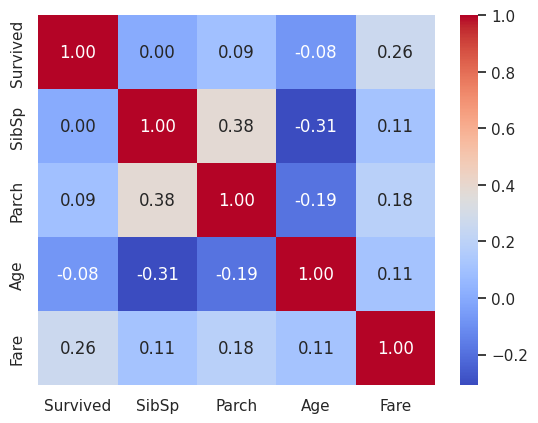

In [138]:
#3.1 Numerical values
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True,fmt='.2f',cmap='coolwarm')

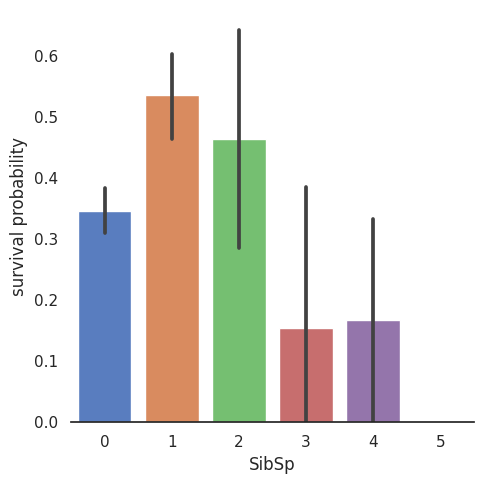

In [139]:
g = sns.catplot(x='SibSp',y='Survived',data=train,kind='bar',palette='muted')
# Explore SibSp feature vs Survived
g.despine(left=True)
g = g.set_ylabels('survival probability')

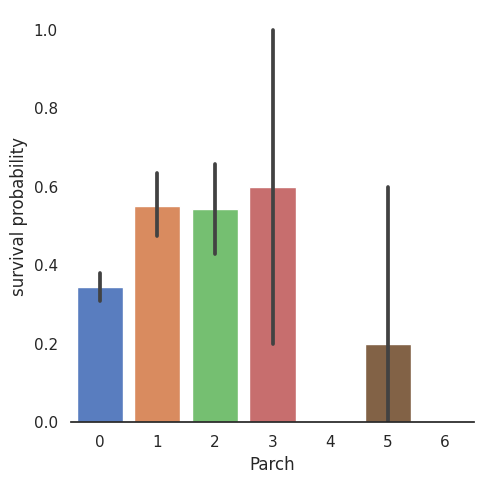

In [140]:
g = sns.catplot(x='Parch',y='Survived',data=train,kind='bar',palette='muted')
# Explore Parch feature vs Survived
g.despine(left=True)
g = g.set_ylabels('survival probability')

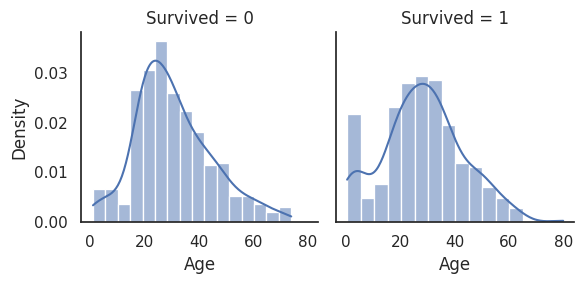

In [141]:
g = sns.FacetGrid(train,col='Survived')
# Explore Age vs Survived
g = g.map(sns.histplot,'Age',kde=True, stat='density')

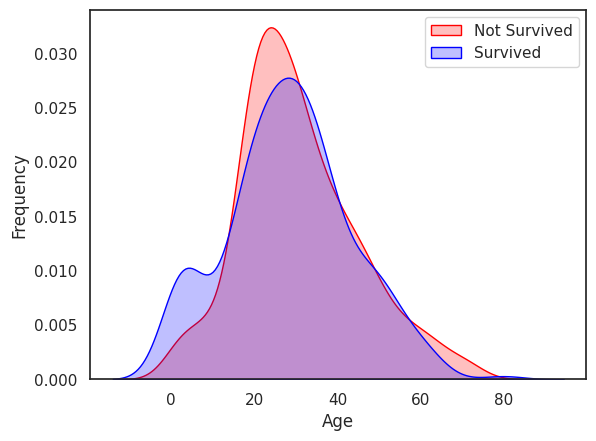

In [142]:
g = sns.kdeplot(train['Age'][(train['Survived']==0)&(train['Age'].notnull())], color='Red', fill=True)
# Explore Age distribution
g = sns.kdeplot(train['Age'][(train['Survived']==1)&(train['Age'].notnull())], ax=g, color='Blue', fill=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

In [143]:
dataset['Fare'].isnull().sum()

1

In [144]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median()) #Fill Fare NaN with median

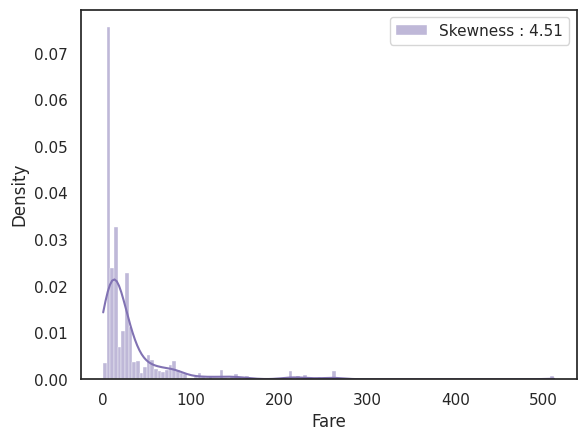

In [145]:
g = sns.histplot(dataset['Fare'],color='m',label='Skewness : %.2f'%(dataset['Fare'].skew()),kde=True,stat='density')
g = g.legend(loc='best')

In [146]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)
# Apply log to Fare to reduce skewness distribution

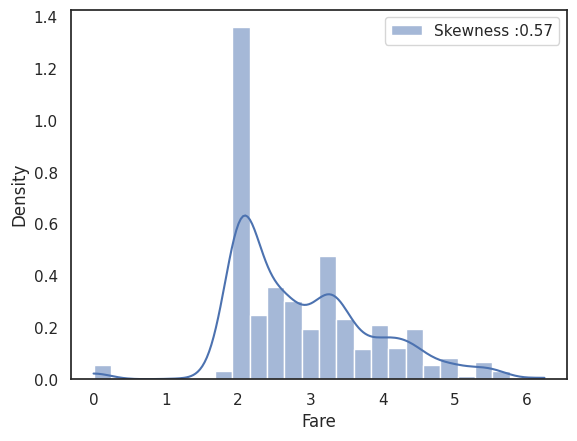

In [147]:
g = sns.histplot(dataset['Fare'],color='b',label='Skewness :%.2f'%(dataset['Fare'].skew()),kde=True,stat='density')
g = g.legend(loc='best')

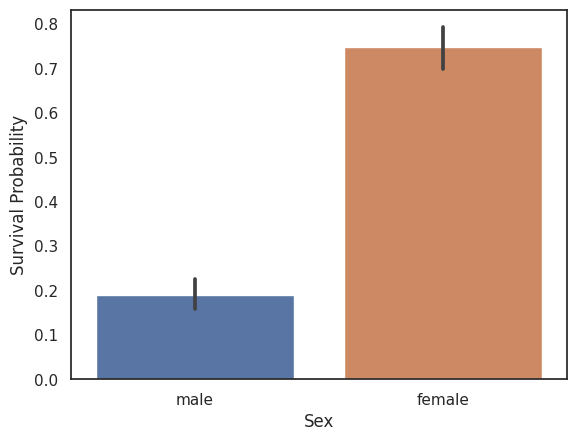

In [148]:
#3.2 Categorical values
g = sns.barplot(x='Sex',y='Survived',data=train) #Sex
g = g.set_ylabel('Survival Probability')

In [149]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


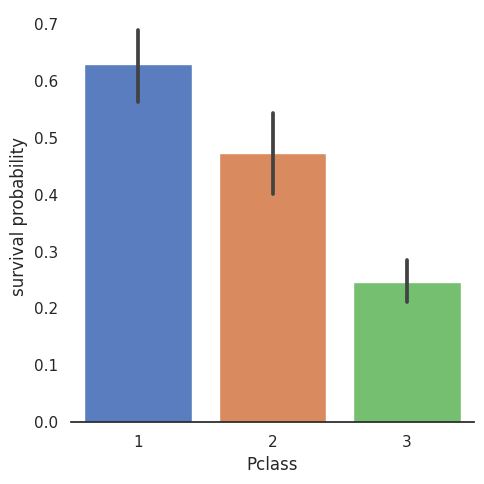

In [150]:
g = sns.catplot(x='Pclass',y='Survived',data=train,kind='bar',palette='muted')
# Explore Pclass vs Survived
g.despine(left=True)
g = g.set_ylabels('survival probability')

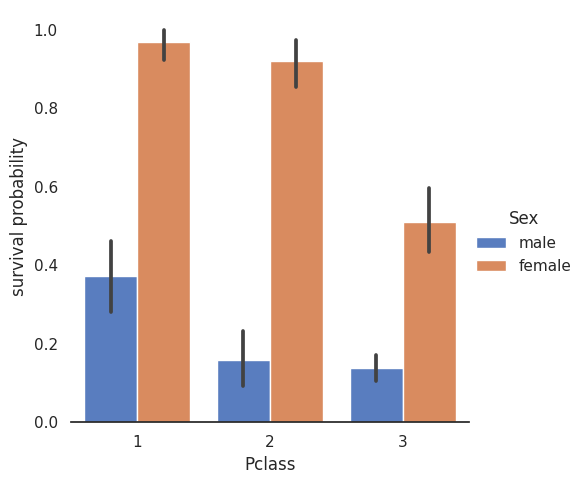

In [151]:
g = sns.catplot(x='Pclass',y='Survived',hue='Sex',data=train,kind='bar',palette='muted')
# Explore Pclass vs Survived by Sex
g.despine(left=True)
g = g.set_ylabels('survival probability')

In [152]:
dataset['Embarked'].isnull().sum()

2

In [153]:
dataset['Embarked'] = dataset['Embarked'].fillna('S') #Fill Embarked NaN with most frequent

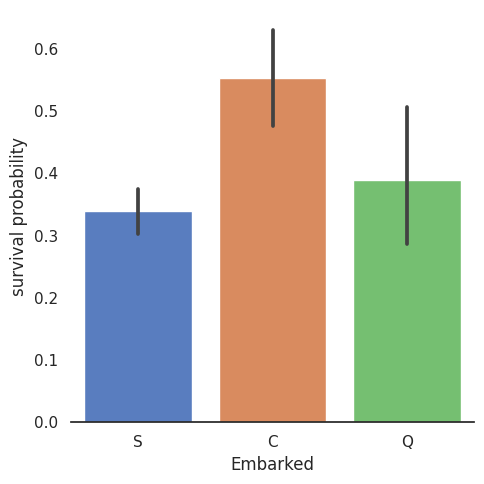

In [154]:
g = sns.catplot(x='Embarked',y='Survived',data=train,kind='bar',palette='muted')
# Explore Embarked vs Survived
g.despine(left=True)
g = g.set_ylabels('survival probability')

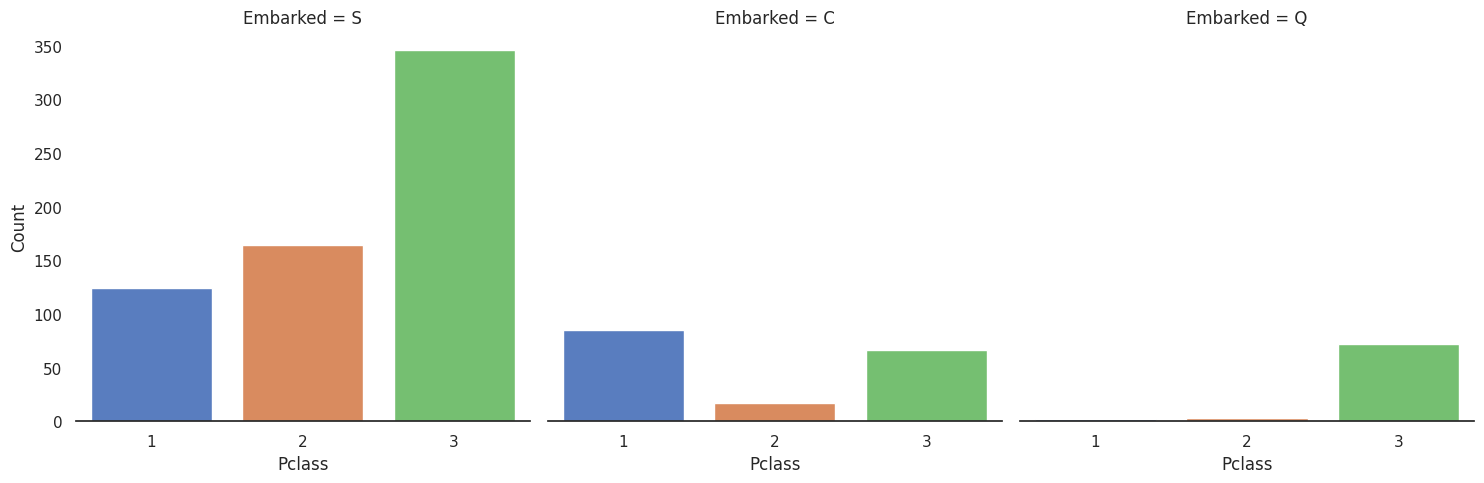

In [155]:
g = sns.catplot(x='Pclass',col='Embarked',data=train,kind='count',palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

4. Filling Missing Values

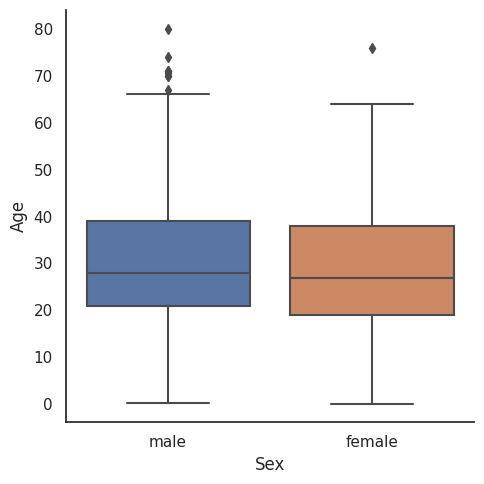

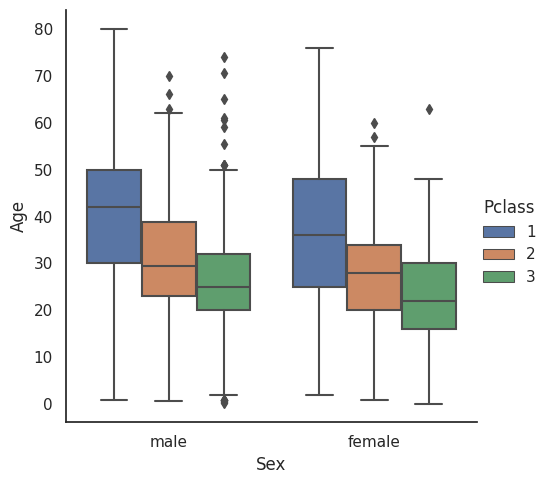

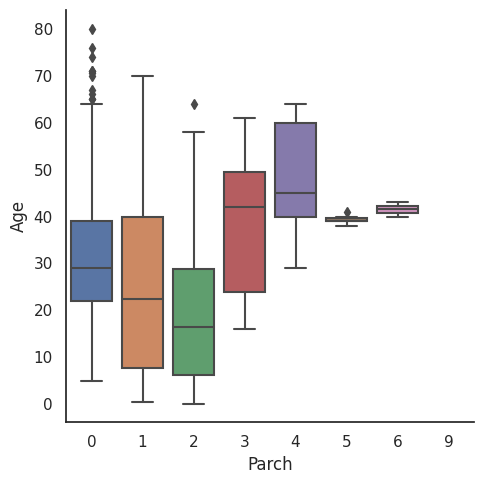

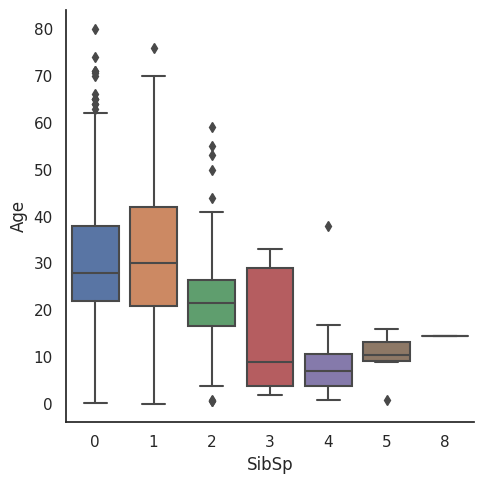

In [156]:
#4.1 Age
g = sns.catplot(y='Age',x='Sex',data=dataset,kind='box')
# Explore Age
g = sns.catplot(y='Age',x='Sex',hue='Pclass',data=dataset,kind='box')
g = sns.catplot(y='Age',x='Parch',data=dataset,kind='box')
g = sns.catplot(y='Age',x='SibSp',data=dataset,kind='box')

In [157]:
dataset['Sex'] = dataset['Sex'].map({'male':0,'female':1})
# convert Sex into categorical value 0 for male and 1 for female

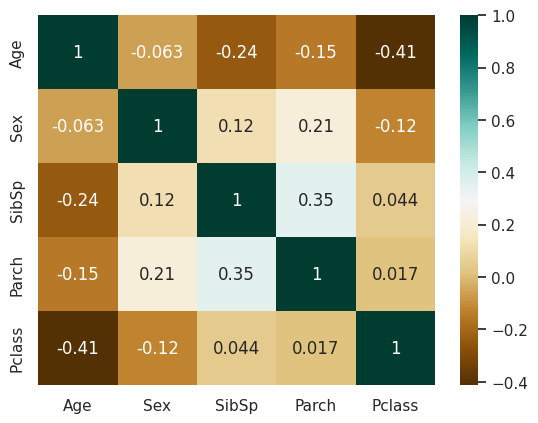

In [158]:
g = sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(),cmap='BrBG',annot=True)

In [159]:
# Filling missing values of Age
''' fill Age with the median age of similar rows according to Pclass, Parch and SibSp '''

index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index) #Index of NaN age rows

for i in index_NaN_age :
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp'])&(dataset['Parch']==dataset.iloc[i]['Parch'])&(dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

<ipython-input-159-8eb119370ebb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-159-8eb119370ebb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-159-8eb119370ebb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-159-8eb119370ebb>:10: SettingWithCopyWarning: 
A value is trying to be se

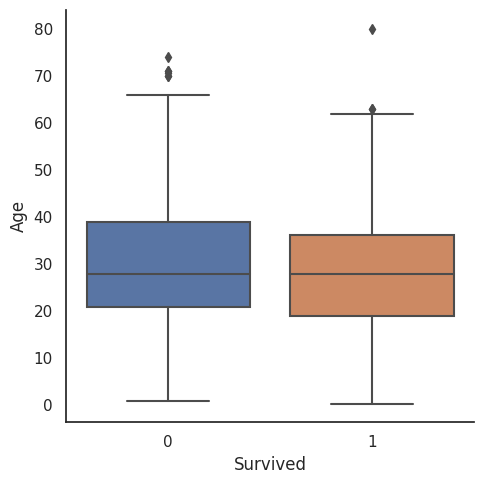

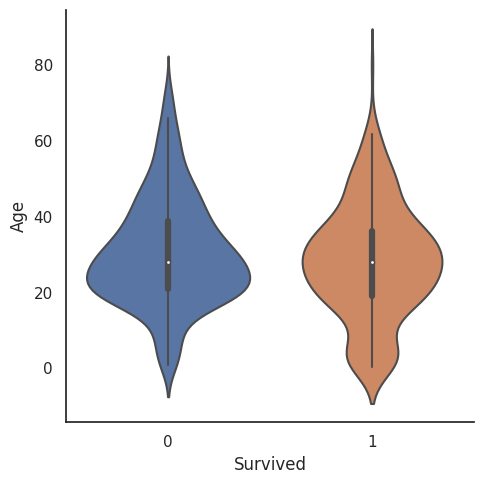

In [160]:
g = sns.catplot(x='Survived',y='Age',data=train,kind='box')
g = sns.catplot(x='Survived',y='Age',data=train,kind='violin')

5. Feature Engineering

In [161]:
#5.1 Name/Title
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object